<a href="https://colab.research.google.com/github/hellocybernetics/Pyro_tutorials/blob/master/Estimate_and_Inference_without_pyro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyro-ppl

    100% |████████████████████████████████| 204kB 25.5MB/s 
    100% |████████████████████████████████| 61kB 22.6MB/s 
  Stored in directory: /root/.cache/pip/wheels/ed/b5/01/c883fa6e02eb51fd67ba2b73f1ddcee42997716394792d57da
  Stored in directory: /root/.cache/pip/wheels/51/3e/a3/b351fae0cbf15373c2136a54a70f43fea5fe91d8168a5faaa4
Successfully built pyro-ppl opt-einsum


## Pyroの基本的な役割
PyroはPyTorchを計算のバックエンドに構えた確率プログラミング言語です。確率プログラミング言語の主な役割は、様々な確率分布からのサンプリングや、同時分布・条件付き分布・周辺分布の取扱を容易にすることです。**まずはTorchを使ってみて、その確率プログラミング言語の必要性を体感してみましょう。**

In [0]:
import torch
import torch.distributions as torchdist

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine

### 分布の記述
まず、肩慣らしに標準正規分布 $\rm {Normal} (0, 1)$ を書いてみましょう。`torch.distributions`  モジュールを使うことで下記のように記述することができます。

In [3]:
normal_dist = torchdist.Normal(loc=torch.tensor(0.), scale=torch.tensor(1.))
normal_dist

Normal(loc: 0.0, scale: 1.0)

### サンプリング
続いて、記述した分布から
$$
x \sim {\rm Normal}(0, 1)
$$
とサンプリングを得るには下記のようにします。

In [4]:
x = normal_dist.sample()
x

tensor(0.0399)

更に同じ分布から独立に複数のサンプルを得たい場合には下記のように、`sample()` メソッドに引数を渡すことで実施します。このとき引数はリストあるいはタプルで渡すようにします。

In [5]:
X1 = normal_dist.sample([3,])
X1

tensor([ 1.0747, -0.5219, -0.5010])

上記のサンプルは各成分が各々独立に正規分布から生成されています。数式で表現するならば下記のようになります。

$$
X_1[i] \sim \rm{Normal}(0, 1)
$$

同じ理屈でもっと多次元の配列を作ることもできます。

In [6]:
X2 = normal_dist.sample([10, 2])
X2

tensor([[-0.8258, -0.3836],
        [ 1.3726, -0.6616],
        [ 1.5686, -0.8907],
        [-0.4262, -1.2156],
        [ 2.3546, -0.6246],
        [ 0.6792, -0.8905],
        [ 0.2586,  0.1164],
        [ 1.6033,  1.4882],
        [ 0.7288,  0.5897],
        [-0.2297, -0.1686]])

上記の配列も同様に各成分が独立に正規分布から生成されています。

$$
X_2[i, j] = \rm{Normal}(0, 1)
$$

配列として取り出すと、もはや元々これが何の分布の話だったのか、情報を持ち合わせていないので注意が必要です。例えば、下記のような2次元正規分布を考えましょう。2次元正規分布からの1つのサンプルは当然2つの要素を持っています。

In [7]:
multi_normal_dist = torchdist.MultivariateNormal(
    loc=torch.tensor([1., -2.]),
    covariance_matrix=torch.tensor([[1., -1.],
                                    [-1., 2.]])
)

multi_normal_dist.sample()

tensor([ 2.6118, -4.3481])

この2次元正規分布から10個のサンプルを得ると、`(10, 2)` の `tensor`が得られますが、この `tensor` の各成分は独立ではありません。各行は独立ですが、各列は2次元の正規分布からの一つのサンプルであり、相関を持っていることに注意する必要があります。



In [8]:
multi_normal_dist.sample([10])

tensor([[ 0.0605, -2.3511],
        [ 0.8840, -0.7532],
        [-0.7491,  0.0411],
        [ 0.4643, -1.0314],
        [-1.5282, -1.8038],
        [ 0.1993, -0.6630],
        [ 0.9128, -2.5010],
        [ 1.8150, -2.7232],
        [ 0.7102, -2.0912],
        [-0.4182, -2.7429]])

長いコードを書いているうちに、ある`tensor` がどういうサンプルのされ方をしたものであったのかを見失うことも起こりうるので注意が必要です。

### 尤度の計算
機械学習ではしばしば確率分布 $p(x)$ の尤度の計算が必要になります。あるサンプル $x^*$ の $p(x)$ における尤度は単純に $p(x^*)$ の値になります。では $\{x_1, x_2, x_3,...,\}$ の尤度はどのように計算するのかというと、

$$
p(x_1)p(x_2)p(x_3)...
$$

と各確率値の積によって表されます。確率値は $[0, 1]$ の値でありサンプルの数が多くなると、$1$ 未満の数の積が連なり非常に小さな値となってしまいます。そこで、コンピュータでは通常、対数尤度というものを計算することにします。

$$
{\rm log}\{p(x_1)p(x_2)p(x_3)...\} = {\rm log}p(x_1) + {\rm log}p(x_2) + {\rm log}p(x_3) + ...
$$

と負の値の足し算になり数値的に安定します。また、$\rm log$ は単調増加関数であるので、微分にとっても符号には影響が無く（絶対値には影響するが）、積が和となっているため都合が良いです。サンプル $x^*$ の対数尤度は簡単に下記のコードで求まります。

In [9]:
sample = multi_normal_dist.sample()
print("*** a sample from 2dim normal: \n", sample)
log_likelihood = multi_normal_dist.log_prob(sample)
print("*** log likelihood of the sample \n", log_likelihood)

*** a sample from 2dim normal: 
 tensor([ 0.1378, -1.1663])
*** log likelihood of the sample 
 tensor(-2.2100)


また複数のサンプルに関しては足し算する前の各々の対数尤度が返ってきます。

In [10]:
samples = multi_normal_dist.sample([5,])
print("*** 5 samples from 2dim normal: \n", sample)
log_likelihoods = multi_normal_dist.log_prob(samples)
print("*** log likelihoods of the samples: \n", log_likelihoods)

*** 5 samples from 2dim normal: 
 tensor([ 0.1378, -1.1663])
*** log likelihoods of the samples: 
 tensor([-2.1829, -2.0011, -2.6910, -2.2002, -1.8725])


### MAP推定
ここでMAP推定を実施してみます。上記の関数と自動微分機能を駆使すれば難しくありません。

#### 訓練データ
人工訓練データを作りますが、パラメータは知らない体で推定をします。

In [0]:
def toy_data():
    true_mu = torch.tensor([2., 3.])
    true_cov = torch.tensor([[2., -3.],[-3, 5]])
    
    X = torchdist.MultivariateNormal(loc=true_mu, 
                                     covariance_matrix=true_cov).sample([100,])
    return X

X_train = toy_data()

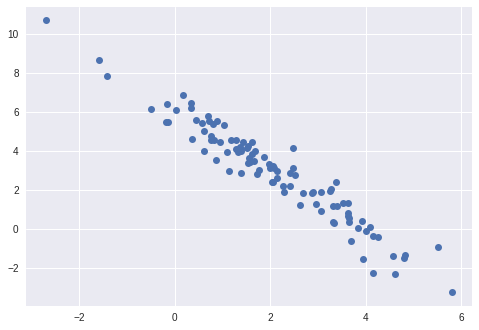

In [12]:
import matplotlib.pyplot as plt

plt.plot(X_train.numpy()[:,0], X_train.numpy()[:,1], "o")

#### 推定のためのモデル
データを可視化して、コレは2次元正規分布に従っていると睨んだとしましょう。すると私達が推定したいパラメータは、平均ベクトルと共分散行列になります。これらをまず初期化しておきます。

In [0]:
mu_param = torch.nn.Parameter(torch.tensor([0., 0.]))
cov_tril_param = torch.nn.Parameter(torch.tensor([[1., 0.],
                                                  [0., 1.]]))

#### 対数尤度関数（最適化の目的関数）
データ $X = \{x_1, \cdots, x_N\}$ に対する対数尤度関数は

$$
{\rm LogLikelihood}(X, \mu, \Sigma) = \frac{1}{N}\sum_{i=1}^N {\rm log}\{{\rm Normal}(x_i \mid \mu, \Sigma)\}
$$

であり、データ $X$ は既に手元にあるので、パラメータ $\mu, \Sigma$ に関して最大化するのが最尤推定法になります。続いて事前分布 $p(\mu)$ と $p(\Sigma)$ を目的関数に考慮するのがMAP推定になります。具体的には下記のように修正されます。

$$
{\rm LogJointProb}(X, \mu, \Sigma) = \frac{1}{N}\sum_{i=1}^N {\rm log}\{{\rm Normal}(x_i \mid \mu, \Sigma)\} + {\rm log}p(\mu) +{\rm log}p(\Sigma)
$$

今回は適当に分散の大きな正規分布を仮定し、無情報事前分布に近い状態にしておきます。

#### 補足
ちなみにベイズの定理よりパラメータの事後分布は

$$
p(\mu, \Sigma \mid X) = \frac{p(X, \mu, \Sigma)}{p(X)}
$$

と表され、この分母は定数になっています。したがって分子の同時分布について最大化すれば良いというのかMAP推定であり、同時分布を

$$
p(X,\mu,\Sigma)=p(X\mid \mu, \Sigma) p(\mu) p(\Sigma)
$$

と表現しつつ、対数を取ることで上記の目的関数が導出されます。

In [0]:
def log_joint_prob(mu_param, cov_param, X):
    
    prior_mu = torchdist.Normal(loc=torch.zeros_like(mu_param),
                                 scale=100*torch.ones_like(mu_param))
    prior_cov = torchdist.Normal(loc=torch.zeros_like(cov_param),
                                 scale=100*torch.ones_like(cov_param))
    
    model = torchdist.MultivariateNormal(
        loc=mu_param, 
        scale_tril=cov_param
    )
    
    return (
        model.log_prob(X).mean() 
        + prior_mu.log_prob(mu_param).mean()
        + prior_cov.log_prob(cov_param).mean()
    )

In [15]:
print("*** initial log joint prob")
log_joint_prob(mu_param, cov_tril_param, X_train)

*** initial log joint prob


tensor(-23.5550, grad_fn=<AddBackward0>)

In [0]:
optimizer = torch.optim.Adam(params=[mu_param, cov_tril_param], lr=1e-3)

In [17]:
for i in range(10000):
    optimizer.zero_grad()
    log_joint_prob_value = log_joint_prob(mu_param, cov_tril_param, X_train)
    loss_value = - log_joint_prob_value
    loss_value.backward()
    optimizer.step()
    
    if (i+1) % 1000 == 0 or (i==0):
        print(loss_value.detach().numpy())

23.554953
16.814312
15.548412
14.782041
14.4432125
14.053167
13.900515
13.896851
13.896435
13.896425
13.896425


In [18]:
"""
def toy_data():
    true_mu = torch.tensor([2., 3.])
    true_cov = torch.tensor([[2., -3.],
                             [-3., 5.]])
    
    X = torchdist.MultivariateNormal(loc=true_mu, 
                                     covariance_matrix=true_cov).sample([100,])
    return X
"""

print("mu map estimated: \n", mu_param.data)
print("cov map estimated \n", cov_tril_param.mm(cov_tril_param.t()).data)

mu map estimated: 
 tensor([2.0524, 2.9367])
cov map estimated 
 tensor([[ 2.3883, -3.6838],
        [-3.6838,  6.1090]])


### 回帰モデル
次に同じようにTorchで回帰モデルを実装していきます。スカラーの入力 $x$ とスカラーの出力 $y$ の関係性が下記の用に多項式で表されると仮定しましょう。

$$
y = -3 + 4x + x^2 + \epsilon
$$

ただし、ここで $\epsilon \sim {\rm Normal}(0, 1)$ の正規乱数としておきます。

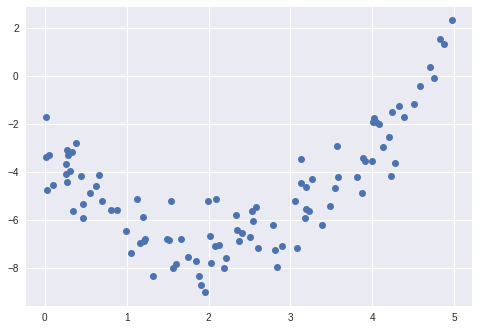

In [19]:
def toy_poly():
    
    x = 5 * torch.rand(100, 1) 
    linear_op = -3 - 4*x + 1*x**2 
    y = torchdist.Normal(linear_op, 1).sample()
    return x, y

x_train, y_train = toy_poly()

plt.plot(x_train.numpy(), y_train.numpy(), "o")

#### モデル
さて、上記のデータを見て、二次関数で表現できると睨んだとしましょう（出来レースですが）。

$$
y = w_0 + w_1x + w_2x^2 + \epsilon
$$

すると、簡単な式変形から下記のような確率モデルを使うことが考えられます（$\epsilon$の分散は既知としているが、未知にすることも当然必要であれば考えられる）。 


$$
y - (w_0 + w_1x + w_2x^2) \sim {\rm Normal}(0,1)
$$

あるいは、分布の平均の方にパラメータを持つ項を吸収させて

$$
y \sim {\rm Normal}(w_0 + w_1x + w_2x^2 ,1)
$$

とできます。事前分布を適当に置いてしまえば、MAP推定に必要な同時分布 $p(w_0, w_1, w_2, x, y)$ が一先ず書き下せますので、その対数値を最大化することで回帰問題を解くことが可能になります。今回も各パラメータに対してはそれぞれ適当な正規分布を仮定してしまいましょう。

$$
{\rm LogJointProb}(w_0, w_1, w_2, X, Y) = \frac{1}{N} \sum_{i=1}^N {\rm Normal}(y_i\mid w_0 + w_1x_i + w_2x_i^2 ,1) +{\rm log} p(w_0) +{\rm log} p(w_1) +{\rm log} p(w_2)
$$

In [0]:
w0 = torch.nn.Parameter(torch.tensor(1.))
w1 = torch.nn.Parameter(torch.tensor(1.))
w2 = torch.nn.Parameter(torch.tensor(1.))

In [0]:
def log_joint_prob(w0, w1, w2, x, y):
    
    prior_w0 = torchdist.Normal(torch.tensor(0.), 10*torch.tensor(1.))
    prior_w1 = torchdist.Normal(torch.tensor(0.), 10*torch.tensor(1.))
    prior_w2 = torchdist.Normal(torch.tensor(0.), 10*torch.tensor(1.))

    linear = w0 + w1*x + w2*x**2
    likelihood = torchdist.Normal(linear, torch.ones_like(linear))
    
    return (
        prior_w0.log_prob(w0).mean() +
        prior_w1.log_prob(w1).mean() +
        prior_w2.log_prob(w2).mean() +
        likelihood.log_prob(y).mean()
    )    


In [22]:
optimizer = torch.optim.Adam(params=[w0, w1, w2], lr=1e-3)

for i in range(30000):
    optimizer.zero_grad()
    log_joint_prob_value = log_joint_prob(w0, w1, w2, x_train, y_train)
    loss_value = - log_joint_prob_value
    loss_value.backward()
    optimizer.step()
    
    if (i+1) % 1000 == 0 or (i==0):
        print(loss_value.detach().numpy())

159.7145
37.539642
20.450272
18.480148
16.616161
14.740344
13.157278
12.070682
11.507385
11.308815
11.248821
11.209596
11.179522
11.163915
11.159591
11.159147
11.159139
11.15914
11.159138
11.159138
11.15914
11.159139
11.159141
11.159139
11.159139
11.159139
11.159139
11.159139
11.159139
11.159138
11.159139


In [23]:
"""
def toy_poly():
    
    x = 5 * torch.rand(100, 1) 
    linear_op = -3 - 4*x + 1*x**2 
    y = torchdist.Normal(linear_op, 1).sample()
    return x, y

"""
print(w0.data)
print(w1.data)
print(w2.data)

tensor(-3.1003)
tensor(-3.9002)
tensor(0.9775)


### 変分推論
ベイズ推論は事後分布 

$$
p(\theta \mid D) = \frac{p(D\mid \theta)p(\theta)}{p(D)}
$$

において、同時分布の最大化に甘んじず（すなわち関数の一番山となる部分だけを探すのではなく）、分布の形状全体を把握しようという試みになります。その試みは一般に困難を極めます。都合の良い尤度関数と都合の良い事前分布を選ばない限りは形状全体を上手に求めることはできません。

したがって、形状全体を知りたいのだが、ある程度簡略化した形状で一番近いものを探せればいいというのが変分推論です。変分モデル $q(\theta; \eta)$ を仮定し（$\eta$は変分パラメータと呼ばれる最適化すべきパラメータである）、$\eta$ の調整で分布の形状を変えること $p(\theta |D)$ に最も近い $q(\theta; \eta)$ を決定します。近いというのはKLダイバージェンスの意味であり

$$
{\rm KL}[q(\theta; \eta) : p(\theta\mid D)] = {\mathbb E}_{q(\theta;\eta)}[{\rm log}q(\theta; \eta)] - {\mathbb E}_{q(\theta;\eta)}[{\rm log}p(\theta)] - {\mathbb E}_{q(\theta;\eta)}[{\rm log}p(D\mid\theta)]
$$

を最小化するような $\eta$ を求めます。

こちらも最適化問題ではありますが、求めているものはパラメータ $\theta $ の値ではなくパラメータ $\theta$ が取りうる値の分布を網羅的に把握するために $\eta$ を最適化していることに注意しましょう。最適化された $\eta$ によって分布 $q(\theta ; \eta)$ が定まり、この分布からサンプリングをしたりすることで、単に点推定で $\theta$ を決めてしまうよりも多くの情報を利用することができるというわけです。

実際の推論では期待値計算の代わりに現在の $\eta$ の値を用いて 

$$
\theta^* \sim q(\theta; \eta)
$$

とサンプリングし、サンプリングされた$\theta^*$ で現在のKLダイバージェンスを計算するということにします（そんなのいい加減すぎる！と思うのであれば、$q(\theta; \eta)$ は現在の $\eta$ を使うとして重点サンプリングなどをしてもいいだろうし、大げさにもMCMCを使ってもいいだろう。単に計算量の問題である）。

$$
{\rm KL}[q(\theta; \eta) : p(\theta\mid D)] \simeq {\rm log}q(\theta^*; \eta) - {\rm log}p(\theta^*) - {\rm log}p(D\mid\theta^*)
$$


#### 変分モデル
回帰問題の例に戻って、パラメータ $w_0, w_1, w_2$ に対してそれぞれ変分モデル

$$
q(w_i ; \eta_i) = {\rm Normal}(\mu_i, \sigma_i)
$$

を仮定しましょう。すなわち各 $w_i$ に対して正規分布を仮定して、あとはそれぞれの平均分散を変分パラメータとして最適化して $w_i$ の分布を得てしまおうということにしたのです。

In [0]:
variational_params = {
    "w0_loc": torch.nn.Parameter(torch.tensor(0.)),
    "w0_scale_log": torch.nn.Parameter(torch.tensor(0.)),
    "w1_loc": torch.nn.Parameter(torch.tensor(0.)),
    "w1_scale_log": torch.nn.Parameter(torch.tensor(0.)),
    "w2_loc": torch.nn.Parameter(torch.tensor(0.)),
    "w2_scale_log": torch.nn.Parameter(torch.tensor(0.)),
}

def variational_model(variational_params):
    """
    Variational model q(w; eta)
    arg: variational parameters "eta"
    return: w ~ q(w; eta)
    """
    w0_q = torchdist.Normal(
        variational_params["w0_loc"],
        torch.exp(variational_params["w0_scale_log"]),
    )
    
    w1_q = torchdist.Normal(
        variational_params["w1_loc"],
        torch.exp(variational_params["w1_scale_log"]),
    )
    
    w2_q = torchdist.Normal(
        variational_params["w2_loc"],
        torch.exp(variational_params["w2_scale_log"]),
    )
    
    return w0_q, w1_q, w2_q

In [25]:
print("*** w0, w1, w2 :variational model with initial variatinal params")
variational_model(variational_params)

*** w0, w1, w2 :variational model with initial variatinal params


(Normal(loc: 0.0, scale: 1.0),
 Normal(loc: 0.0, scale: 1.0),
 Normal(loc: 0.0, scale: 1.0))

### KLダイバージェンス
変分モデルを書き終えたので、後は変分モデルから出てくるサンプルを引数としたKLダイバージェンスを書き下せばいいです。KLダイバージェンスの近似は実は下記の通り、MAP推定でも利用してきたLog Joint Prob（データ $D$とパラメータ $\theta$の対数同時確率）
と新たに出てきたVariational model （勝手に仮定したパラメータ $\theta $ の事後分布）の対数確率値で構成されています。

$$
\begin{align}
{\rm KL}[q(\theta; \eta) : p(\theta\mid D)] &\simeq {\rm log}q(\theta^*; \eta) - {\rm log}p(\theta^*) - {\rm log}p(D\mid\theta^*) \\\ 
& = {\rm log}q(\theta^*; \eta) - {\rm LogJointProb}(\theta^*, D)
\end{align}
$$

ですので、実装上はMAP推定に使っていた目的関数をそのまま流用できます。

すなわち実装は、$\eta$ の関数である変分モデルを作り、パラメータ $\theta$ をサンプリングできるようにして、そのサンプリング値$\theta^*$をMAP推定で使っていた目的関数に代入してやれば良いのです。更に、サンプリングされた $\theta^*$の$q(\theta; \eta)$ におけるの対数確率値も追加してやれば、目的関数の作成は終了です。

In [0]:
def kl_divergence(variational_params, x, y):
    w0_q, w1_q, w2_q = variational_model(variational_params)
    
    w0_sample = w0_q.sample()
    w1_sample = w1_q.sample()    
    w2_sample = w2_q.sample()
    
    log_joint_prob_value = log_joint_prob(w0_sample, w1_sample, w2_sample, x, y)
    log_variational_prob_value = (
        w0_q.log_prob(w0_sample) +
        w1_q.log_prob(w1_sample) +
        w2_q.log_prob(w2_sample)
    )
    
    return log_variational_prob_value - log_joint_prob_value

In [0]:
optimizer = torch.optim.SGD(params=variational_params.values(), lr=1e-8)

for i in range(9000):
    optimizer.zero_grad()
    loss_value =kl_divergence(variational_params, x_train, y_train)
    loss_value.backward()
    optimizer.step()
    
    if (i+1) % 300 == 0 or (i==0):
        print(loss_value.detach().numpy())

51.307236
30.228342
24.399588
94.61427
54.46742
256.63162
46.625977
121.564
83.602974
36.613064
38.916714
52.55144
46.949112
29.521364
66.69088
175.45775
31.18562
46.020782
128.05133
28.738707
21.411339
122.938194
56.800346
67.371475
24.99657
57.510315
18.435207
26.601477
33.188393
34.200565
61.512882


In [0]:
for k, v in variational_params.items():
    print("{} : {}".format(k, v))

w0_loc : 1.2164202871645102e-06
w0_scale_log : -6.172373900881212e-07
w1_loc : -1.4097398661760963e-06
w1_scale_log : 9.952343589247903e-07
w2_loc : 1.3103788205626188e-06
w2_scale_log : -2.068474259431241e-06


#### 学習の仕方を変える
さて、結果は上手く言ったと言えるのでしょうか…？どうやらイマイチな気がしますね。変分推論では、変分パラメータを同時に一気に最適化するのは難しいので、実際には変分パラメータを1つずつ更新していく必要があります。

具体的には学習のコードを下記のように書き直します。まずは `optimizer` を各々のパラメータに対して設定し、個別にパラメータを1つずつ更新できるようにしておきましょう。

In [0]:
optimizers = {}
for key in variational_params.keys():
    optimizers[key] = torch.optim.SGD(params=[variational_params[key]], lr=1e-6)

optimizers

{'w0_loc': SGD (
 Parameter Group 0
     dampening: 0
     lr: 1e-06
     momentum: 0
     nesterov: False
     weight_decay: 0
 ), 'w0_scale_log': SGD (
 Parameter Group 0
     dampening: 0
     lr: 1e-06
     momentum: 0
     nesterov: False
     weight_decay: 0
 ), 'w1_loc': SGD (
 Parameter Group 0
     dampening: 0
     lr: 1e-06
     momentum: 0
     nesterov: False
     weight_decay: 0
 ), 'w1_scale_log': SGD (
 Parameter Group 0
     dampening: 0
     lr: 1e-06
     momentum: 0
     nesterov: False
     weight_decay: 0
 ), 'w2_loc': SGD (
 Parameter Group 0
     dampening: 0
     lr: 1e-06
     momentum: 0
     nesterov: False
     weight_decay: 0
 ), 'w2_scale_log': SGD (
 Parameter Group 0
     dampening: 0
     lr: 1e-06
     momentum: 0
     nesterov: False
     weight_decay: 0
 )}

In [0]:
for i in range(9000):

    def step(key):
        optimizers[key].zero_grad()
        loss_value =kl_divergence(variational_params, x_train, y_train)
        loss_value.backward()
        optimizers[key].step()
        return loss_value
        
    if i % 3 == 0:
        loss_value = step("w0_loc")
    if i % 3 == 1:
        loss_value = step("w1_loc")
    if i % 3 == 2:
        loss_value = step("w2_loc")
        
    if (i+1) % 900 == 0 or (i==0):
        print(loss_value.detach().numpy())

44.325314
37.59131
30.394562
55.613743
61.8145
182.16685
25.236744
229.55133
33.00921
26.89841
12.4200115


In [0]:
for k, v in variational_params.items():
    print("{} : {}".format(k, v))

w0_loc : 8.712218004802708e-06
w0_scale_log : 0.0
w1_loc : -1.857791721704416e-05
w1_scale_log : 0.0
w2_loc : -1.4663711226603482e-05
w2_scale_log : 0.0


#### 入力変数の無相関化


In [0]:
w0 = torch.nn.Parameter(torch.tensor(1.))
w1 = torch.nn.Parameter(torch.tensor(1.))
w2 = torch.nn.Parameter(torch.tensor(1.))

In [0]:
def log_joint_prob(w1, w2, x, y):
    
    z1 = x
    z2 = x**2
    
    z1 = z1 - z1.mean()
    z2 = z2 - z2.mean()
    
#      w0 = learned_w1 * x.mean() + learned_w2 * x2.mean()
#     prior_w0 = torchdist.Normal(torch.tensor(0.), 10*torch.tensor(1.))
    prior_w1 = torchdist.Normal(torch.tensor(0.), 10*torch.tensor(1.))
    prior_w2 = torchdist.Normal(torch.tensor(0.), 10*torch.tensor(1.))

    linear = w1*z1 + w2*z2
    likelihood = torchdist.Normal(linear, torch.ones_like(linear))
    
    return (
#         prior_w0.log_prob(w0).mean() +
        prior_w1.log_prob(w1).mean() +
        prior_w2.log_prob(w2).mean() +
        likelihood.log_prob(y).mean()
    )    


In [0]:
variational_params = {
#     "w0_loc": torch.nn.Parameter(torch.tensor(0.)),
#     "w0_scale_log": torch.nn.Parameter(torch.tensor(0.)),
    "w1_loc": torch.nn.Parameter(torch.tensor(0.)),
    "w1_scale_log": torch.nn.Parameter(torch.tensor(0.)),
    "w2_loc": torch.nn.Parameter(torch.tensor(0.)),
    "w2_scale_log": torch.nn.Parameter(torch.tensor(0.)),
}

def variational_model(variational_params):
    """
    Variational model q(w; eta)
    arg: variational parameters "eta"
    return: w ~ q(w; eta)
    """
#     w0_q = torchdist.Normal(
#         variational_params["w0_loc"],
#         torch.exp(variational_params["w0_scale_log"]),
#     )
    
    w1_q = torchdist.Normal(
        variational_params["w1_loc"],
        torch.exp(variational_params["w1_scale_log"]),
    )
    
    w2_q = torchdist.Normal(
        variational_params["w2_loc"],
        torch.exp(variational_params["w2_scale_log"]),
    )
    
    return w1_q, w2_q

In [0]:
def kl_divergence(variational_params, x, y):
    w1_q, w2_q = variational_model(variational_params)
    
    w1_sample = w1_q.sample()    
    w2_sample = w2_q.sample()
    
    log_joint_prob_value = log_joint_prob(w1_sample, w2_sample, x, y)
    log_variational_prob_value = (
        w1_q.log_prob(w1_sample) +
        w2_q.log_prob(w2_sample)
    )
    
    return log_variational_prob_value - log_joint_prob_value

In [38]:
optimizer = torch.optim.SGD(params=variational_params.values(), lr=1e-8)

for i in range(9000):
    optimizer.zero_grad()
    loss_value =kl_divergence(variational_params, x_train, y_train)
    loss_value.backward()
    optimizer.step()
    
    if (i+1) % 300 == 0 or (i==0):
        print(loss_value.detach().numpy())

90.803825
41.785004
23.601
39.208557
19.011414
181.76736
37.377632
21.076927
45.070988
34.490356
35.906746
63.28737
28.20584
93.55271
18.816729
24.749609
31.443726
26.173645
107.47343
48.67775
48.917828
20.044004
19.199318
20.335903
19.125805
45.805664
19.173203
22.83492
28.226173
46.18383
21.605198


In [39]:
for k, v in variational_params.items():
    print("{} : {}".format(k, v))

w1_loc : -2.330399865968502e-06
w1_scale_log : 3.587514285641191e-08
w2_loc : -2.8125245421506406e-07
w2_scale_log : 1.359101929665485e-06
